In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import logging
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

from cnaster.config import JSONConfig
from cnaster.io import get_spots, get_meta, get_umis
from cnaster.sim.io import get_truth
from cnaster.sim.clone import (
    Clone,
    get_clones,
    query_clones,
    construct_frac_cnas,
    get_cnas,
)

In [3]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(filename)s:%(lineno)d - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

logger = logging.getLogger(__name__)

# NOTES
- current sim. configuration assumes tumor purity of unity

In [4]:
run_id = 0
cpath = "/Users/mw9568/repos/cnaster/sim_config.json"
sample_name = "cnaster_002"

config = JSONConfig.from_file(cpath)

In [5]:
spots = get_spots(config, run_id, sample_name)
meta = get_meta(config, run_id, sample_name)
truth = get_truth(config, run_id, sample_name)

df = pd.merge(spots, meta, on="barcode")
df = pd.merge(df, truth, on="barcode")
df

2025-06-17 10:42:10 - cnaster.io - INFO - io.py:13 - Reading spots from /Users/mw9568/scratch/cnaster/run0/cnaster_002/cnaster_002_visium.tsv.gz


,barcode,x,y,z,umis,snp_umis,clone,tumor_purity
0,VIS00000,-15.0,0.000000,2.5,4255,363,-1,0.0
1,VIS00001,-14.0,0.000000,2.5,1187,340,-1,0.0
2,VIS00002,-13.0,0.000000,2.5,2453,886,-1,0.0
3,VIS00003,-12.0,0.000000,2.5,2764,324,-1,0.0
4,VIS00004,-11.0,0.000000,2.5,2995,362,-1,0.0
...,...,...,...,...,...,...,...,...
4895,VIS04895,84.5,59.755753,2.5,2386,372,4,1.0
4896,VIS04896,85.5,59.755753,2.5,2528,432,4,1.0
4897,VIS04897,86.5,59.755753,2.5,2414,419,4,1.0
4898,VIS04898,87.5,59.755753,2.5,4533,173,4,1.0


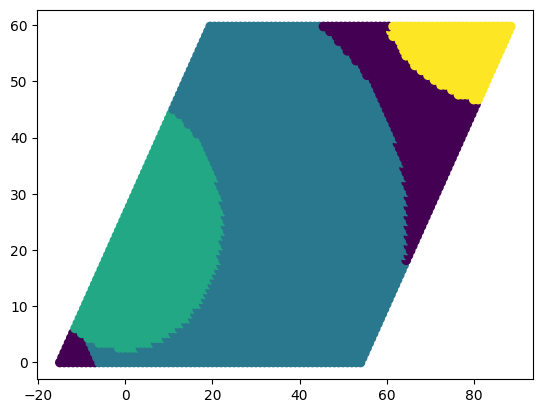

In [6]:
pl.scatter(df["x"], df["y"], c=df["clone"])

In [6]:
clone_ids = np.unique(df["clone"])
clone_ids

array([-1,  1,  2,  4])

In [10]:
cnas_per_clone = get_cnas(config, clone_ids)

Text(0, 0.5, 'RDR ratio')

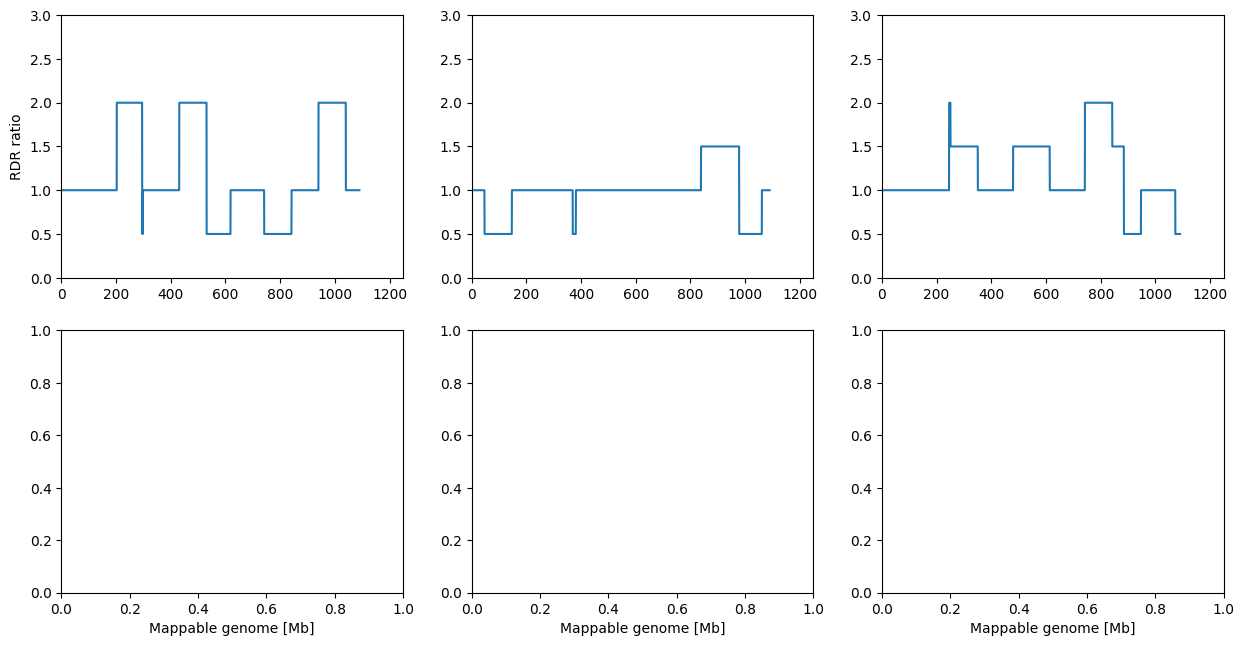

In [18]:
num_segments = config.mappable_genome_kbp // config.segment_size_kbp
segments_mb = (config.segment_size_kbp / 1.0e3) * np.arange(num_segments)

fig, axes = plt.subplots(2, len(cnas_per_clone), figsize=(15, 7.5))

for ii, cnas in enumerate(cnas_per_clone):
    rdrs, bafs = construct_frac_cnas(num_segments, config.segment_size_kbp, 1.0, cnas)

    axes[0, ii].plot(segments_mb, rdrs)
    axes[1, ii].set_xlabel("Mappable genome [Mb]")

    axes[0, ii].set_xlim(0.0, 1.25e3)
    axes[0, ii].set_ylim(0.0, 3.0)

axes[0, 0].set_ylabel("RDR ratio")

# Done.